**Проект: HR-аналитика**

**Цели проекта**
    
    1. Построить модель, которая предсказывает уровень удовлетворённости сотрудника работой.
    2.Построить модель, которая прогнозирует увольнение сотрудника.


**Задача 1: Предсказание уровня удовлетворённости сотрудника**


Этапы работы:


- Загрузка данных: Подготовить тренировочную выборку и тестовые данные.
- Предобработка данных: Выявить пропуски и провести очистку данных.
- Исследовательский анализ данных: Исследовать данные, выявить закономерности и скорректировать подход к обработке признаков.
- Подготовка данных: Организовать пайплайн обработки с кодировкой данных.
- Обучение моделей: Обучить несколько моделей (линейную и дерево решений), подобрать гиперпараметры, оценить результат с метрикой SMAPE.
- Анализ: Определить лучшую модель на основе результатов.



**Задача 2: Прогноз увольнения сотрудника**

Этапы работы:
- Загрузка данных: Загрузить и объединить необходимые данные с учётом предсказанного job_satisfaction_rate.
- Предобработка данных: Провести ту же очистку и проверку, что и в задаче 1.
- Исследовательский анализ и портрет: Определить профили сотрудников, склонных к увольнению, и визуализировать взаимосвязь job_satisfaction_rate с увольнениями.
- Подготовка данных: Добавить новый признак job_satisfaction_rate в процесс обработки.
- Обучение моделей: Обучить и протестировать как минимум три модели с подбором гиперпараметров. Оценить результаты по метрике ROC-AUC.
- Анализ: Определить лучшую модель и обосновать результаты.




In [ ]:
!pip install phik -q

In [2]:
pip install --upgrade scikit-learn -q

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install imbalanced-learn -q

Note: you may need to restart the kernel to use updated packages.


In [4]:
!pip install shap -q

In [5]:
# Импорт необходимых библиотек
import time
import phik
import sklearn
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import shap

from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer 
from sklearn.svm import SVC
from scipy.stats import ttest_ind
from sklearn.ensemble import RandomForestRegressor
from imblearn.over_sampling import SMOTENC
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
from sklearn.linear_model import LinearRegression, LogisticRegression

from sklearn.metrics import (
    make_scorer, 
    roc_auc_score, 
    confusion_matrix
)
from sklearn.preprocessing import (
    StandardScaler,
    OneHotEncoder,
    OrdinalEncoder,
    LabelEncoder,
    MinMaxScaler,
    PolynomialFeatures,
    RobustScaler
)    

In [6]:
# Определение константы
RANDOM_STATE = 42

## Задача 1: предсказание уровня удовлетворённости сотрудника

### Этап 1: Загрузка данных

In [7]:
train_rate_df = pd.read_csv('/datasets/train_job_satisfaction_rate.csv')
test_features_df = pd.read_csv('/datasets/test_features.csv')
test_target_df = pd.read_csv('/datasets/test_target_job_satisfaction_rate.csv')

### Этап 2: Предобработка данных

In [8]:
def preprocess_csv(df_name):
    # Вывод информации о датафрейме
    print("\n--- Информация о DataFrame ---")
    df_name.info()
    
 # Приведение названий столбцов к нижнему регистру и замена пробелов на "_"
    df_name.columns = [col.lower().replace(" ", "_") for col in df_name.columns]
    print("\n--- Названия столбцов после преобразования ---")
    print(", ".join(df_name.columns))

    # Проверка на наличие дублей
    subset_cols = df_name.columns
    duplicated_count = len(df_name[df_name.duplicated(subset=subset_cols)])
    print(f"\n--- Количество дублированных строк до удаления: {duplicated_count} ---")
    
    # Удаление дублей
    df_name = df_name.drop_duplicates(subset=subset_cols, keep='first').reset_index(drop=True)
    duplicated_count_after = len(df_name[df_name.duplicated(subset=subset_cols)])
    print(f"\n--- Количество дублированных строк после удаления: {duplicated_count_after} ---")
    # Вывод количества пропусков
    print(df_name.isnull().sum())
# Вывод уникальных значений для столбцов с типами 'object' и 'category'
    print("\n--- Уникальные значения в категориальных и строковых столбцах ---")
    for column in df_name.columns:
        if df_name[column].dtype == 'object' or df_name[column].dtype.name == 'category':
            print(f"Столбец '{column}': {df_name[column].unique()}")
# Вывод описания числовых столбцов
    print("\n--- Описание числовых столбцов ---")
    numeric_columns = df_name.select_dtypes(include=['number']).columns
    if numeric_columns.any():
        print(df_name[numeric_columns].describe().round(2))
    else:
        print("Числовые столбцы отсутствуют")

    # Возврат обработанного DataFrame
    return display(df_name.head())
"""Проводит предобработку данных в таблице:
она приводит названия столбцов к нижнему регистру, заменяет пробелы на '_',
проверяет датасет на наличие дубликатов и удаляет их, выводит количество
пропусков, проверяет уникальные значения в столбцах, выводит описание числовых столбцов.


Args:
    df_name: принимает на вход название датафрейма, который необходимо предварительно обработать.
    
Returns:
    возвращает основную информацию о таблице, названия столбцов после преобразования, 
    Количество дублированных строк до удаления и после, уникальные значения в категориальных
    и строковых столбцах, описание числовых столбцов и возвращает обработанный датафрейм.

"""

help(preprocess_csv)

Help on function preprocess_csv in module __main__:

preprocess_csv(df_name)



In [9]:
# ознакомимся с первой таблицей, в которой содержится тренировочная выборка
preprocess_csv(train_rate_df)


--- Информация о DataFrame ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     4000 non-null   int64  
 1   dept                   3994 non-null   object 
 2   level                  3996 non-null   object 
 3   workload               4000 non-null   object 
 4   employment_years       4000 non-null   int64  
 5   last_year_promo        4000 non-null   object 
 6   last_year_violations   4000 non-null   object 
 7   supervisor_evaluation  4000 non-null   int64  
 8   salary                 4000 non-null   int64  
 9   job_satisfaction_rate  4000 non-null   float64
dtypes: float64(1), int64(4), object(5)
memory usage: 312.6+ KB

--- Названия столбцов после преобразования ---
id, dept, level, workload, employment_years, last_year_promo, last_year_violations, supervisor_evaluation, salary, job_satisf

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,155278,sales,junior,medium,2,no,no,1,24000,0.58
1,653870,hr,junior,high,2,no,no,5,38400,0.76
2,184592,sales,junior,low,1,no,no,2,12000,0.11
3,171431,technology,junior,low,4,no,no,2,18000,0.37
4,693419,hr,junior,medium,1,no,no,3,22800,0.20


В таблице содержится 4000 строк и 10 столбцов.

С типами данных в датасете все в порядке.

Дублированные значения отсутствуют.

Присутствует несколько пропусков: 6 в столбце с отделом в котором работает сотрудник и 4 в столбце с уровнем занимаемой должности. Разберемся с ними на этапе составления пайплайна

Есть сотрудники, у которых зарплата выше среднего, однако это нельзя назвать выбросами. 

Названия столбцов приведены к нижнему регистру и записаны через нижнее подчеркивание.

In [10]:
# ознакомимся со второй таблицей, в которой содержатся входные признаки тестовой выборки
preprocess_csv(test_features_df)


--- Информация о DataFrame ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1998 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 140.8+ KB

--- Названия столбцов после преобразования ---
id, dept, level, workload, employment_years, last_year_promo, last_year_violations, supervisor_evaluation, salary

--- Количество дублированных строк до удаления: 0 ---

--- Количество дублированных ст

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800
1,686555,hr,junior,medium,1,no,no,4,30000
2,467458,sales,middle,low,5,no,no,4,19200
3,418655,sales,middle,low,6,no,no,4,19200
4,789145,hr,middle,medium,5,no,no,5,40800


In [11]:
# Заменяем пустые строки в столбце workload, dept на NaN
test_features_df['workload'] = test_features_df['workload'].replace(" ", np.nan)
test_features_df['dept'] = test_features_df['dept'].replace(" ", np.nan)
print(test_features_df['workload'].unique())

print(test_features_df['dept'].unique())
print(test_features_df.isna().sum())

['medium' 'low' 'high' nan]
['marketing' 'hr' 'sales' 'purchasing' 'technology' nan]
id                       0
dept                     3
level                    1
workload                 1
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
dtype: int64



В датасете 9 колонок и 2000 строк. дубликаты и выбросы отсутствуют.

В таблице есть пять пропусков. Значения с пробелами были заменены на пропуски для дальнейшей обработки в пайплайне.



In [12]:
# ознакомимся с третьей таблицей, в которой содержится целевой признак тестовой выборки
preprocess_csv(test_target_df)


--- Информация о DataFrame ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     2000 non-null   int64  
 1   job_satisfaction_rate  2000 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 31.4 KB

--- Названия столбцов после преобразования ---
id, job_satisfaction_rate

--- Количество дублированных строк до удаления: 0 ---

--- Количество дублированных строк после удаления: 0 ---
id                       0
job_satisfaction_rate    0
dtype: int64

--- Уникальные значения в категориальных и строковых столбцах ---

--- Описание числовых столбцов ---
              id  job_satisfaction_rate
count    2000.00                2000.00
mean   552765.21                   0.55
std    253851.33                   0.22
min    100298.00                   0.03
25%    339052.00                   0.38
50%   

,id,job_satisfaction_rate
0,130604,0.74
1,825977,0.75
2,418490,0.60
3,555320,0.72
4,826430,0.08


В таблице 2000 строк и 2 столбца. Пропусков, аномалий и дубликатов нет.

что удалось сделать на этапе предобработки данных:


- Первая таблица: Содержит 4000 строк и 10 столбцов. Есть 6 пропусков в dept и 4 в level. Дубликаты отсутствуют, данные структурированы, выбросов нет, названия столбцов оформлены корректно.


- Вторая таблица: Включает 2000 строк и 9 столбцов. Найденo 5 пропусков: 3 в dept, 1 в level, и 1 в workload. Пустые строки заменены на NaN. Аномалий и дубликатов нет, данные готовы к обработке в пайплайне.


- Третья таблица: Содержит 2000 строк и 2 столбца. Пропуски, дубликаты и выбросы отсутствуют. Распределение целевого признака выглядит корректным, данные готовы к анализу

### Этап 3: Исследовательский анализ данных

Для начала необходимо составить графики распределения наблюдений в каждой таблице, чтобы составить общее представление о данных. чтобы не строить графики отдельно для каждого столбца, создадим функцию, благодаря которой за одну строчку можно создать графики для кажого столбца датафрейма.

In [13]:
def col_plot(df, cols):
    for col in cols:
        plt.figure(figsize=(12, 5))

        if pd.api.types.is_numeric_dtype(df[col]):
            unique_vals = df[col].nunique()

            # Если немного уникальных значений — считаем признак дискретным
            if unique_vals <= 20:
                sns.countplot(x=col, data=df, color='lightblue', edgecolor='black')
                plt.title(f'Countplot: {col} (дискретный признак)')
                plt.grid(True)
            else:
                mean_val = df[col].mean()
                median_val = df[col].median()

                plt.subplot(1, 2, 1)
                plt.hist(df[col], bins=30, alpha=0.7, color='lightblue', edgecolor='black')
                plt.axvline(mean_val, color='red', linestyle='dashed', linewidth=2, label=f'Среднее: {mean_val:.2f}')
                plt.axvline(median_val, color='green', linestyle='dashed', linewidth=2, label=f'Медиана: {median_val:.2f}')
                plt.legend()
                plt.title(f'Гистограмма: {col}')
                plt.grid(True)

                plt.subplot(1, 2, 2)
                sns.boxplot(x=df[col], color='lightblue', showfliers=True)
                plt.title(f'Boxplot: {col}')
                plt.grid(True)

        else:
            df[col].value_counts().plot(kind='bar', color='grey', edgecolor='black')
            plt.title(f'Распределение категорий: {col}')
            plt.xticks(rotation=45)
            plt.grid(True)

        plt.tight_layout()
        plt.show()


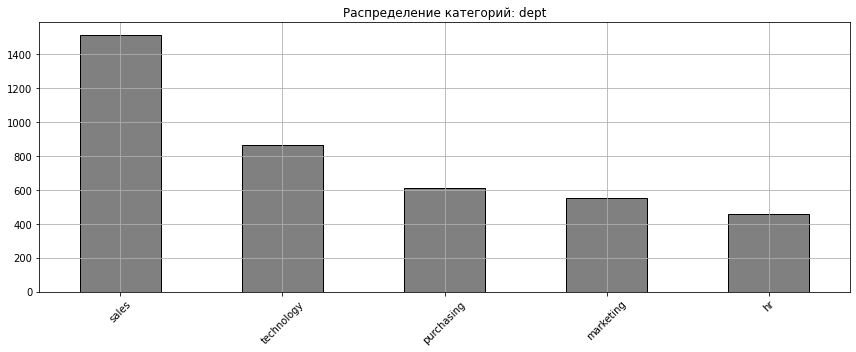

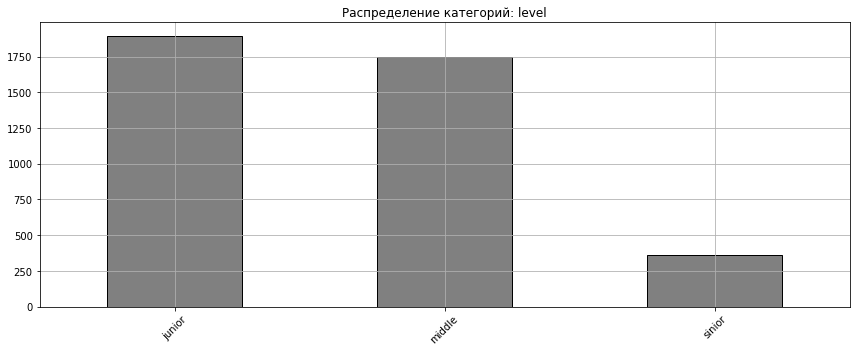

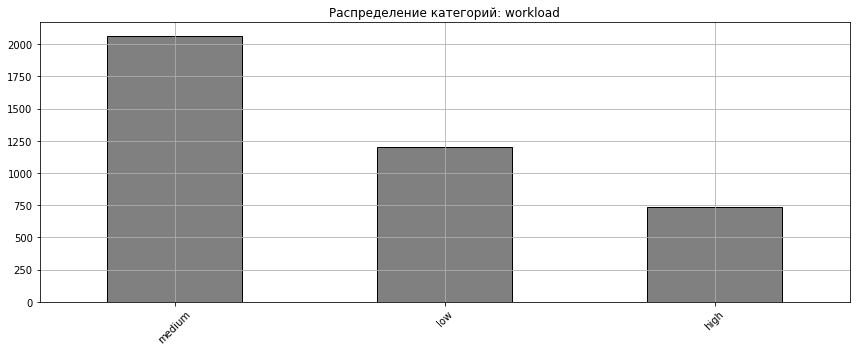

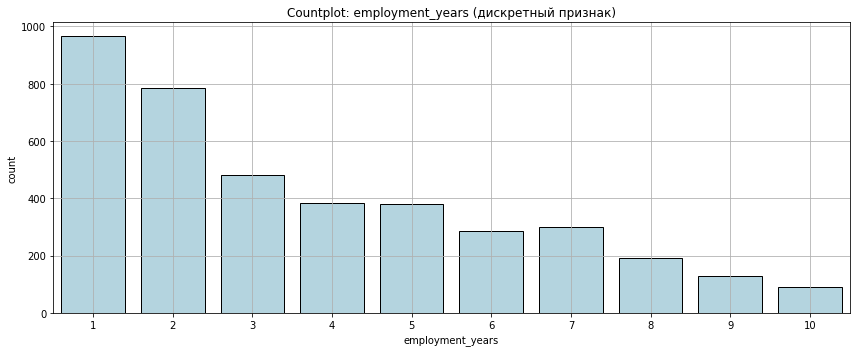

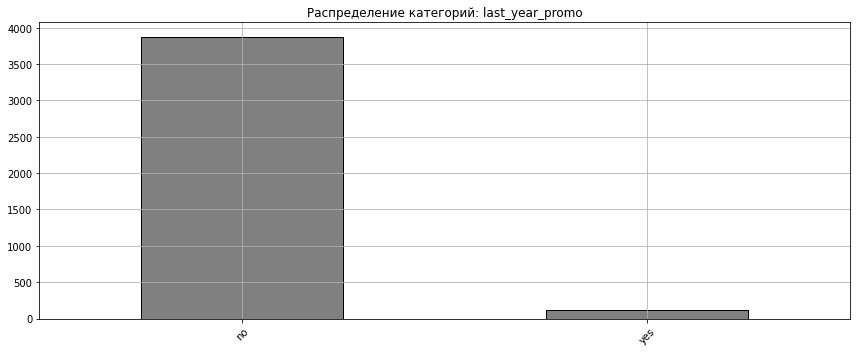

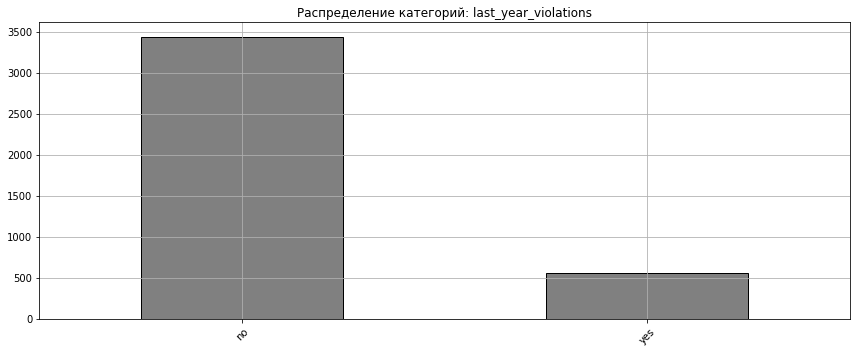

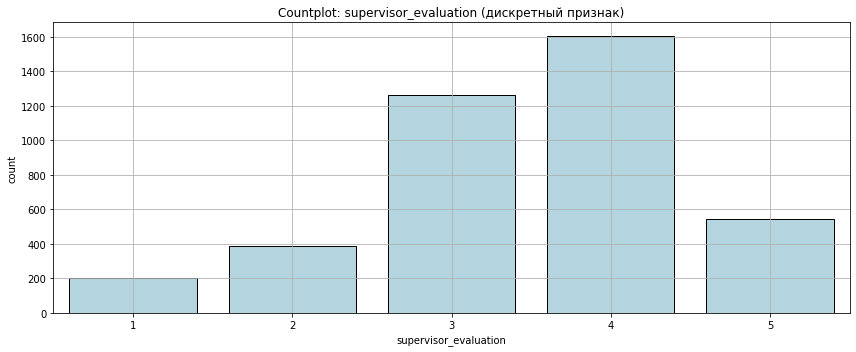

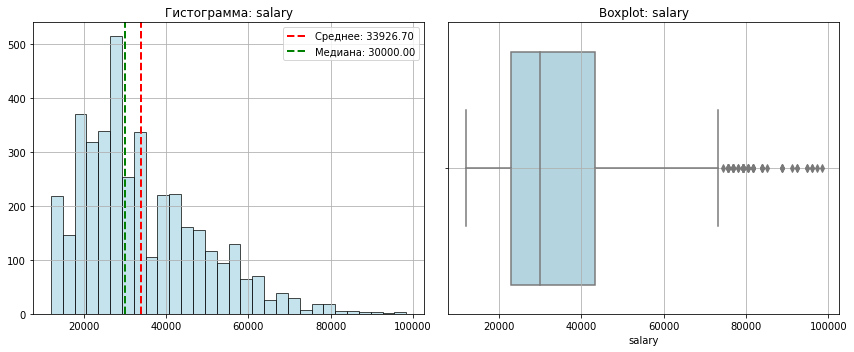

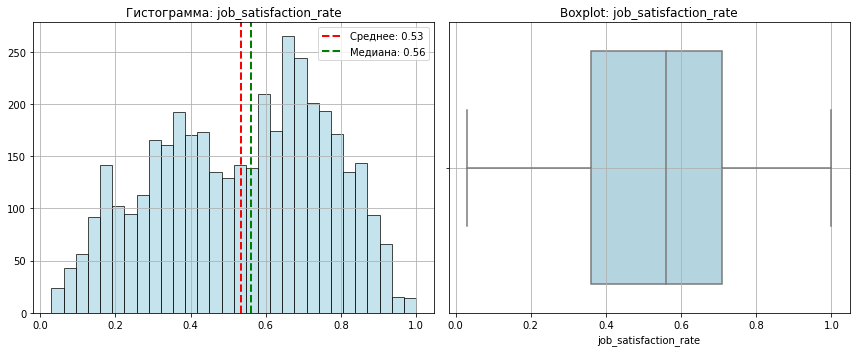

In [14]:
# построим графики для первой таблицы
col_plot(train_rate_df, train_rate_df.columns[1:])

В тренировочной выборке чаще всего встречаются сотрудники из отдела продаж, в то время как в hr-отделе содержится в три раза меньше наблюдений. Данные распределены неравномерно, необходимо будет использовать стратификацию.

В таблице представлено большое количество junior и middle сотрудников (около 1750), в то время как sinior-ов крайне мало (~300)

Загруженность работников чаще всего средняя, однако более 1000 сотрудников поделились, что у них низкая загруженность, а 750 человек упомянули о высоком уровне ответственности.

Длительность работы в компании в среднем равняется 3-4 годам. Среднее статистическое смещено в большую сторону, по сравнению с медианой, и сигнализирует о том, что в компании есть сотрудники, которые уже давно здесь работают. Однако, гистограмма демонстрирует, что большинство работников были наняты около года назад. По боксплоту видно, что разброс значений варьируется от 1 до 10 лет. Большая часть работников трудоустроены в компании от 2 до 6 лет.


В прошлом году повышение было только у ~ 100 сотрудников, в то время как остальные повышения не получали.

Более 500 сотрудников нарушили трудовой договор в прошлом году. 


Большинство руководителей удовлетворены качеством работы своих сотрудников на 4 балла. Они крайне редко отмечают качество работника низкой оценкой. 


Зарплаты в компании чаще всего находятся в диапазоне от 22 до 42 тысяч. Среднее равно ~34 тысячам и на 4 тысячи превышают медианное значение. В совокупности с удлиненным правым хвостом гистограммы и выбросами, такое смещение свидетельствует о том, что в компании есть сотрудники с зарплатой более 80 тысяч. Данные распределены неравномерно.

Средний уровень удовлетворенности работой находится на отметке 0.5 из 1. На на видно, что в распределении присутствует два пика: первый в области меньше середины, второй на уровне 0.7. Значит работники по-разному оценивают условия работы. Кому-то все нравится (а кому-то нет). Среднее немного смещено влево, следовательно отметок около минимального значения довольно много. 

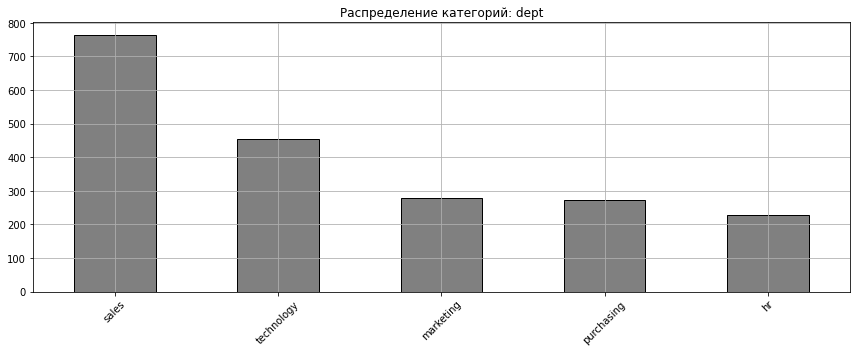

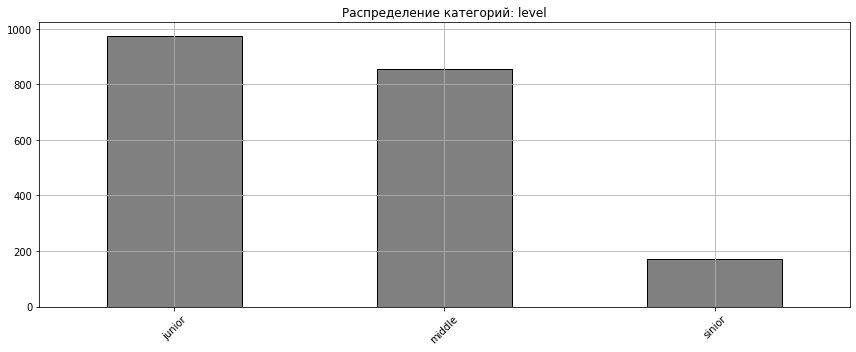

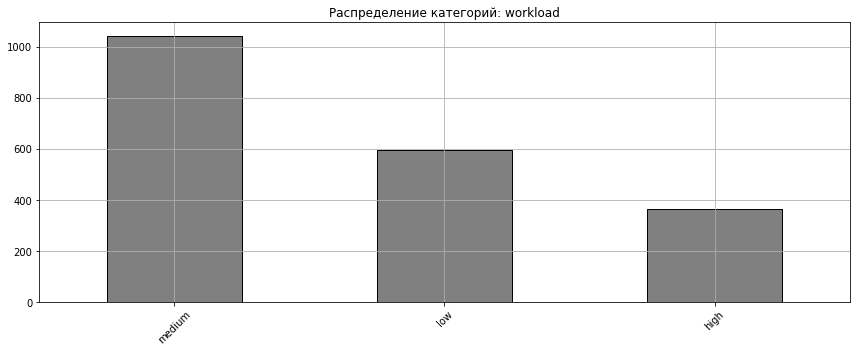

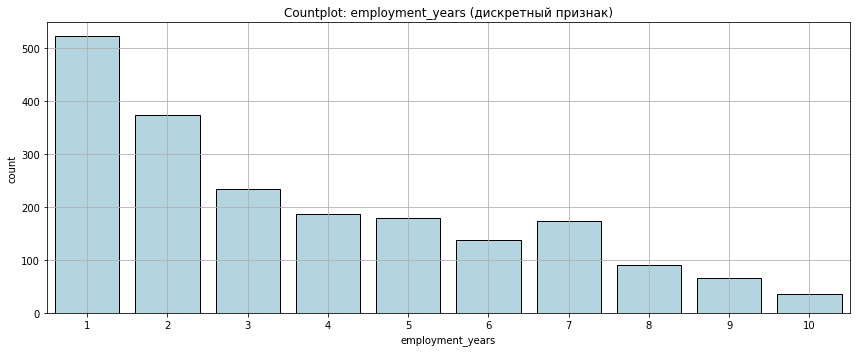

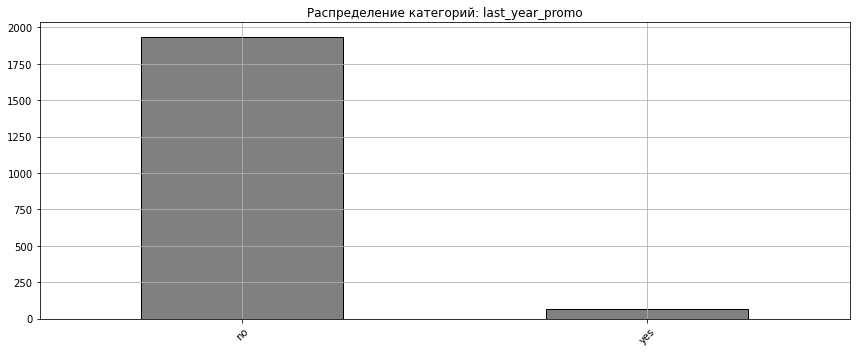

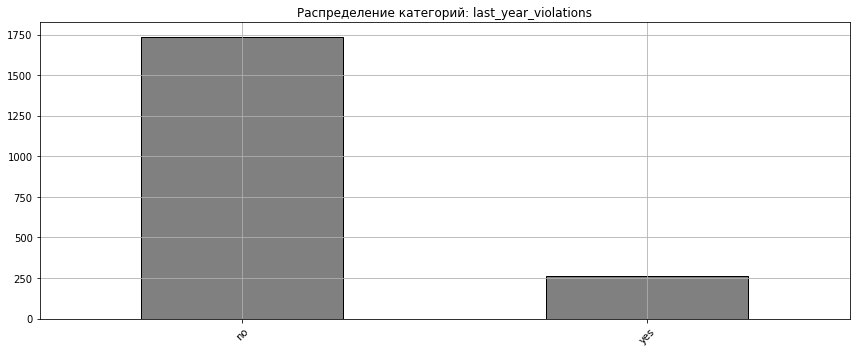

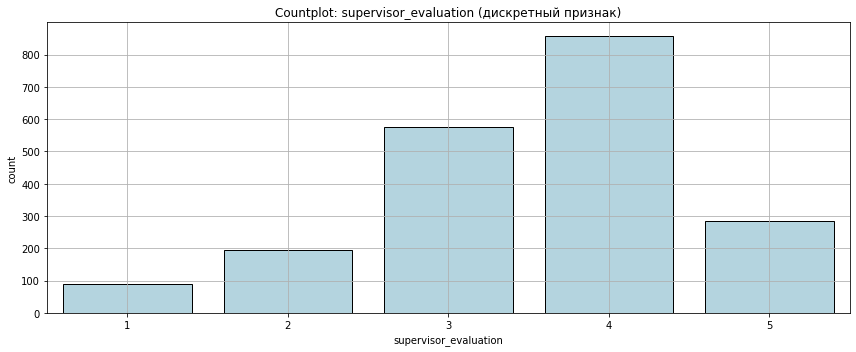

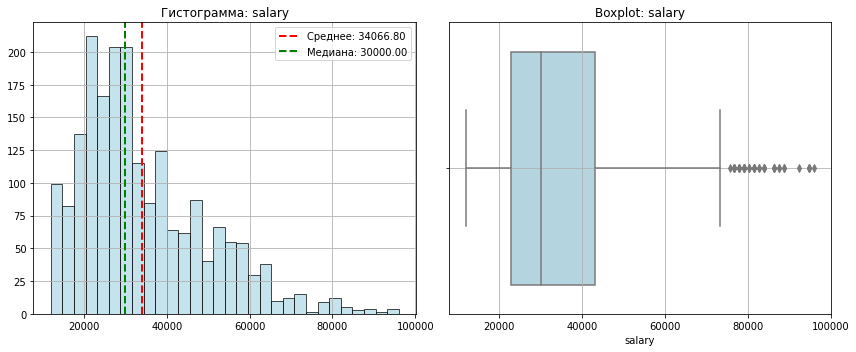

In [15]:
# построим графики для второй таблицы
col_plot(test_features_df, test_features_df.columns[1:])

Распределение отдела работы схоже с тренировочной выборкой. Отдел продаж лидирует по популярности, а рекрутеры на последнем месте. 

В структуре распределения уровня навыков сотрудников все осталось так же как и в тренировочной выборке, только значений стало меньше в два раза.

У подавляющего большинства работников средний уровень загруженности, низкий уровень встречается реже и высокий лишь у ~18% сотрудников.

Распределение стажа сотрудников в компании очень схоже с тренировочной выборкой. Более 25% сотрудников работают в компании около года. Около 50 сотрудников устроены более 10 лет.

Повышение получали в прошлом году крайне редко.

Нарушали трудовой договор ~13% сотрудников

Руководители чаще всего отмечали своих сотрудников оценкой в 4 балла. Так же присутствуют выбросы в стороне меньших значений, но их менее 100.

Распределение заработной платы имеет длинный хвост справа, так же как и в тренировочной выборке. Это значит, что есть сотрудники зарабатывающие намного больше, чем остальные.



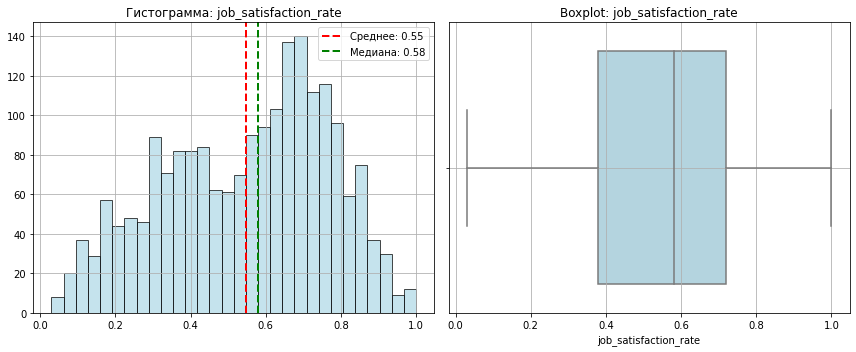

In [16]:
# построим графики для третьей таблицы
col_plot(test_target_df, test_target_df.columns[1:])

Сами сотрудники в среднем на 60% довольны своей работой. Однако, гистограмма демонстрирует, что отметку в 0.5 ставят реже, чем, например, 0.4 или 0.6

построим тепловую карту, отражающую коэффициент корреляции Фи, который находит взаимосвязь между категориальными, порядковыми и интервальными признаками. Чем ближе его значение по модулю к 1, тем сильнее связь.

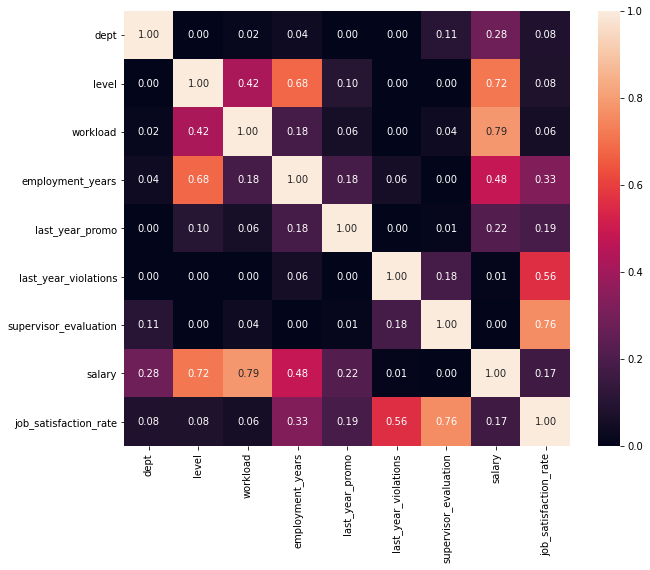

In [17]:
interval_cols = [
    'salary',
    'job_satisfaction_rate'
]

plt.figure(figsize=(10, 8))
sns.heatmap(train_rate_df.drop('id', axis=1).phik_matrix(
    interval_cols=interval_cols), annot=True, fmt='.2f')
plt.show()

Сильные корреляции:

- Уровень зарплаты демонстрирует заметную связь с job_satisfaction_rate. Это ожидаемо, так как заработная плата часто влияет на удовлетворённость работой.

- Оценка руководителя также оказывает влияние: положительная оценка руководства связана с более высокой удовлетворённостью.

- Зарплата и стаж связаны положительно: с ростом стажа может увеличиваться заработная плата.

Слабая или отсутствующие корреляции:

- Признак стаж имеет слабую корреляцию с удовлетворённостью, что может означать, что стаж работы менее важен для оценки условий труда.

- Негативные или слабые связи между другими признаками, например, last_year_violations, могут быть важны для прогнозирования увольнений

Выводы:

В тренировочной выборке больше всего сотрудников в отделе продаж, а в HR — меньше всего. Junior и middle занимают большинство позиций, загруженность чаще всего средняя. Стаж работы варьируется от 1 до 10 лет, зарплаты в среднем составляют ~34 тысячи, но есть выбросы. Уровень удовлетворённости имеет два пика: часть сотрудников довольны, часть — недовольны.

В тестовой выборке структура отделов и должностей схожа с тренировочной. Средняя загруженность преобладает, стаж работы и зарплаты распределены аналогично. Повышения редки, нарушения трудового договора встречались у ~13% сотрудников. Оценки руководителей в основном 3–4 балла.

Уровень удовлетворённости сотрудников тестовой выборки ~60%, но распределение неоднородное, с пиками около 0.4 и 0.6. Данные готовы к дальнейшему анализу.

Признаки с сильными корреляциями важно учитывать при обучении моделей.

Данные готовы для дальнейшей обработки: масштабирования и кодирования

### Этап 4: Подготовка данных

Подготовку признаков выполним в пайплайне, дополнив пайплайн шагом предобработки. При кодировании необходимо учитывать особенности признаков и моделей. Будем использовать как минимум два кодировщика.


In [18]:
# Сортировка и сброс индекса для каждой таблицы
train_rate_df = train_rate_df.sort_values(by='id').reset_index(drop=True)
test_features_df = test_features_df.sort_values(by='id').reset_index(drop=True)
test_target_df = test_target_df.sort_values(by='id').reset_index(drop=True)

# Загрузка данных
X_train = train_rate_df.drop(['id', 'job_satisfaction_rate'], axis=1)
y_train = train_rate_df['job_satisfaction_rate']
X_test = test_features_df.drop(['id'], axis=1)
y_test = test_target_df['job_satisfaction_rate']

print('количество дублированных строк во входных признаках тренировочной и тестовой выборок:', X_train.duplicated().sum(), X_test.duplicated().sum())
print('размерность выборок:', X_train.shape, X_test.shape)
# Списки признаков
ohe_columns = ['dept', 'last_year_promo', 'last_year_violations']
ord_columns = ['level', 'workload']
num_columns = ['employment_years', 
               'supervisor_evaluation',
               'salary'
               ]

# Пайплайн для OHE-кодирования
ohe_pipe = Pipeline([
    ('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
    ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False))
])

# Пайплайн для Ordinal-кодирования
ord_pipe = Pipeline([
    ('simpleImputer_before_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
    ('ord', OrdinalEncoder(
        categories=[
            ['junior', 'middle', 'sinior'], 
            ['low', 'medium', 'high']
        ], 
        handle_unknown='use_encoded_value', unknown_value=np.nan
    )),
    ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
])

# Пайплайн для числовых данных с добавлением полиномиальных признаков
num_pipe = Pipeline([
    ('imputer', SimpleImputer(missing_values=np.nan, strategy='mean')),
    ('scaler', StandardScaler()),
    ('poly', PolynomialFeatures(degree=2, include_bias=False)), 
    ('select', SelectKBest(score_func=f_classif, k='all'))   
])

# Общий ColumnTransformer для подготовки данных
data_preprocessor = ColumnTransformer([
    ('ohe', ohe_pipe, ohe_columns),
    ('ord', ord_pipe, ord_columns),
    ('num', num_pipe, num_columns)
], remainder='passthrough')

data_preprocessor

количество дублированных строк во входных признаках тренировочной и тестовой выборок: 1492 557
размерность выборок: (4000, 8) (2000, 8)


ColumnTransformer(remainder='passthrough',
                  transformers=[('ohe',
                                 Pipeline(steps=[('simpleImputer_ohe',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('ohe',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 ['dept', 'last_year_promo',
                                  'last_year_violations']),
                                ('ord',
                                 Pipeline(steps=[('simpleImputer_before_ord',
                                                  SimpleImputer(strategy='m...
                                                                 handle_unknown='use_encoded_value',
                                                                 unknown_value=nan)),
                                                 ('simpleImputer_after_ord',
                                                  SimpleImputer(strategy='most_frequent'))]),
                                 ['level', 'workload']),
                                ('num',
                                 Pipeline(steps=[('imputer', SimpleImputer()),
                                                 ('scaler', StandardScaler()),
                                                 ('poly',
                                                  PolynomialFeatures(include_bias=False)),
                                                 ('select',
                                                  SelectKBest(k='all'))]),
                                 ['employment_years', 'supervisor_evaluation',
                                  'salary'])])

Для подготовки данных был создан единый пайплайн, включающий обработку пропусков, кодирование признаков и трансформацию числовых данных. Пропущенные значения заполнялись наиболее частыми значениями для категорий. 

Кодирование категорий выполнялось с использованием двух методов: One-Hot Encoding для номинальных данных и Ordinal Encoding для упорядоченных признаков. Это позволило учесть особенности данных и их важность для моделей.


Числовые признаки были масштабированы с помощью StandardScaler для нормализации, дополнены полиномиальными признаками и сокращены до наиболее значимых с использованием SelectKBest. Такой подход помог учесть как линейные, так и нелинейные зависимости, улучшая качество данных для обучения. 

Созданный пайплайн позволяет эффективно объединять все этапы предобработки данных для моделей

### Этап 5: Обучение моделей

Обучим две модели: одну линейную, а в качестве второй — дерево решений. Подберем гиперпараметры для обеих моделей с помощью RandomizedSearchCV.

Выберем лучшую модель и проверим её качество. Выбор будем делать на основе новой метрики — SMAPE («симметричное среднее абсолютное процентное отклонение»). 

In [19]:
# Собственная метрика SMAPE
def smape_scorer(y_true, y_pred):
    return 100 / len(y_true) * np.sum(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred)))

scorer = make_scorer(smape_scorer, greater_is_better=False)

# Пайплайн для линейной регрессии
model_lr = Pipeline([
    ('preprocessor', data_preprocessor),
    ('model', LinearRegression())
])

param_grid_lr = {
    'preprocessor__num__scaler': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough'],
    'preprocessor__num__poly__degree': [1, 2]
}

print(" Поиск гиперпараметров для Linear Regression:")
start = time.time()
linear_mod_rs = RandomizedSearchCV(
    model_lr,
    param_distributions=param_grid_lr,
    cv=5,
    scoring=scorer,
    random_state=RANDOM_STATE,
    n_jobs=-1,
    n_iter=8,
    verbose=1
)
linear_mod_rs.fit(X_train, y_train)
print(f" Linear Regression обучение завершено за {round(time.time() - start, 2)} сек")
print("Лучшая модель (Linear Regression):\n", linear_mod_rs.best_estimator_)
print("SMAPE (кросс-валидация):", -linear_mod_rs.best_score_)

# Пайплайн для Random Forest
model_rf = Pipeline([
    ('preprocessor', data_preprocessor),
    ('model', RandomForestRegressor(random_state=RANDOM_STATE))
])

param_grid_rf = {
    'preprocessor__num__scaler': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough'],
    'preprocessor__num__poly__degree': [1, 2, 3],
    'model__n_estimators': [50, 100, 150],
    'model__max_depth': [4, 6, 8],
    'model__min_samples_leaf': [3, 5, 10]
}

print("\n Поиск гиперпараметров для Random Forest:")
start = time.time()
forest_mod_rs = RandomizedSearchCV(
    model_rf,
    param_distributions=param_grid_rf,
    cv=5,
    scoring=scorer,
    random_state=RANDOM_STATE,
    n_iter=8,
    n_jobs=-1,
    verbose=1
)
forest_mod_rs.fit(X_train, y_train)
print(f" Random Forest обучение завершено за {round(time.time() - start, 2)} сек")
print("Лучшая модель (Random Forest):\n", forest_mod_rs.best_estimator_)
print("SMAPE (кросс-валидация):", -forest_mod_rs.best_score_)

# Выбор лучшей модели
if linear_mod_rs.best_score_ > forest_mod_rs.best_score_:
    best_model = linear_mod_rs.best_estimator_
    best_name = "Linear Regression"
    best_cv_score = -linear_mod_rs.best_score_
else:
    best_model = forest_mod_rs.best_estimator_
    best_name = "Random Forest"
    best_cv_score = -forest_mod_rs.best_score_

print(f"\n Лучшая модель: {best_name}")
print(f"SMAPE на кросс-валидации: {best_cv_score:.4f}")

# Оценка на тестовой выборке 
y_test_pred = best_model.predict(X_test)
smape_test = smape_scorer(y_test, y_test_pred)
print(f" SMAPE на тестовой выборке ({best_name}): {smape_test:.4f}")

 Поиск гиперпараметров для Linear Regression:
Fitting 5 folds for each of 8 candidates, totalling 40 fits
 Linear Regression обучение завершено за 8.04 сек
Лучшая модель (Linear Regression):
 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['dept', 'last_year_promo',
  

1. Линейная регрессия


Лучший результат для линейной регрессии был достигнут с помощью MinMaxScaler и PolynomialFeatures без включения лишних признаков.

Результаты:
Метрика SMAPE на тренировочной выборке: 22.76 — модель способна хорошо адаптироваться к обучающим данным.



2. Random Forest


Лучший результат достигнут при:
max_depth=8 — ограниченная глубина дерева помогает избежать переобучения.
min_samples_leaf=3 — регулировка количества признаков делает модель стабильной.

Метрика SMAPE на тестовой выборке: 14.95 — модель показывает лучшее качество на тестовых данных, и достигает цели SMAPE <= 15.

In [20]:
# обучаем пайплайн предобработки
data_preprocessor.fit(X_train, y_train)

# определяем коэффициенты признаков
lr_coeffs = linear_mod_rs.best_estimator_.named_steps['model'].coef_

# Извлечение названий признаков
processed_features = data_preprocessor.get_feature_names_out()

# Создание таблицы
coefficients_table = pd.DataFrame({ 
    'Feature': processed_features,           
    'Coefficient': lr_coeffs                
})

coefficients_table.sort_values(by='Coefficient', ascending=False)

,Feature,Coefficient
10,num__salary,1.906498
8,num__employment_years,0.448420
9,num__supervisor_evaluation,0.281194
14,num__supervisor_evaluation^2,0.236402
4,ohe__last_year_promo_yes,0.161178
12,num__employment_years supervisor_evaluation,0.055189
1,ohe__dept_purchasing,0.019204
2,ohe__dept_sales,0.009791
0,ohe__dept_marketing,-0.033455
15,num__supervisor_evaluation salary,-0.086806


Коэффициенты линейной регрессии показывают, что наиболее значимыми являются признаки num__salary, num__employment_years и num__supervisor_evaluation. 

In [21]:
# Убедимся, что пайплайн обучен
data_preprocessor.fit(X_train, y_train)

# Извлечение названий обработанных признаков
processed_features = data_preprocessor.get_feature_names_out()

# Вывод названий и значимости признаков дерева решений
model = forest_mod_rs.best_estimator_.named_steps['model']
importances = model.feature_importances_

# Убедимся, что длины совпадают
if len(processed_features) > len(importances):
    processed_features = processed_features[:len(importances)]

# Создаём таблицу
importances_table = pd.DataFrame({
    'Feature': processed_features,
    'Importance': importances
})

# Сортировка по важности
importances_table = importances_table.sort_values(by='Importance', ascending=False)

# Вывод таблицы
print(importances_table)

                          Feature  Importance
9      num__supervisor_evaluation    0.721870
8           num__employment_years    0.081467
5   ohe__last_year_violations_yes    0.055277
10                    num__salary    0.053544
6                      ord__level    0.044713
7                   ord__workload    0.014284
4        ohe__last_year_promo_yes    0.011202
0             ohe__dept_marketing    0.006251
2                 ohe__dept_sales    0.006132
3            ohe__dept_technology    0.003783
1            ohe__dept_purchasing    0.001478


Наиболее значимый признак — num__supervisor_evaluation с важностью 0.72, за ним следуют num__salary (0.05) и num__employment_years (0.08).

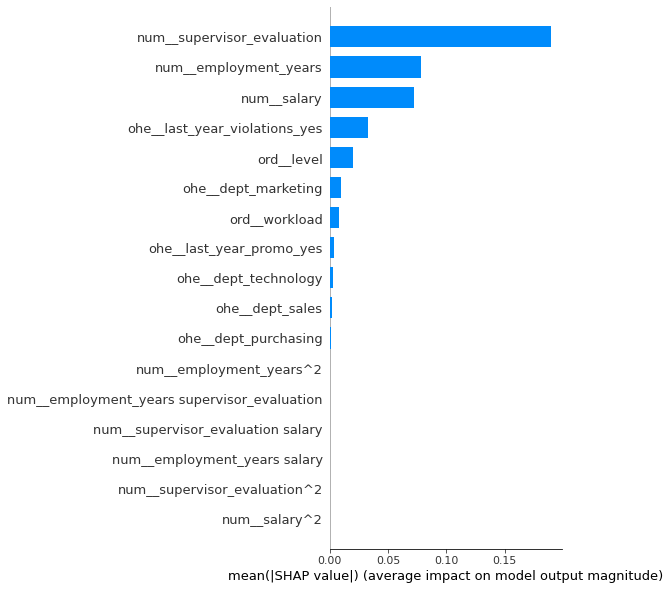

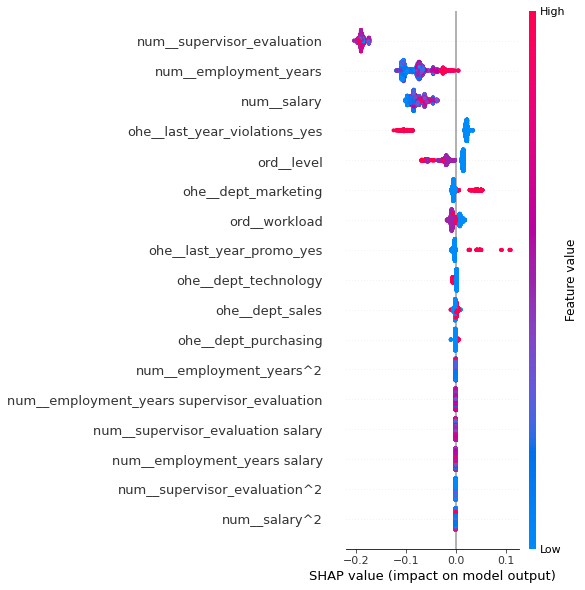

In [22]:
# Преобразуем обучающие данные
X_train_transformed = data_preprocessor.transform(X_train)

# Получаем названия признаков и обрезаем до нужной длины
feature_names = data_preprocessor.get_feature_names_out()

# Инициализация SHAP-объяснителя
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train_transformed)

# Построение bar plot
shap.summary_plot(shap_values, X_train_transformed, feature_names=feature_names, plot_type="bar")

# Построение summary plot
shap.summary_plot(shap_values, X_train_transformed, feature_names=feature_names)

Shap-графики подтвердили, что наиболее важным признаком является num__supervisor_evaluation. Более высокие оценки руководства уводят предсказанные значения в сторону понижения. наличие нарушений трудового договора в прошлом году чаще уводит в сторону роста значения.

Также можно отметить, что умноженные друг на друга или полиноминальные признаки в степени выше единицы влияют на предсказания модели меньше.

### Этап 6: Оформление выводов

1. Линейная регрессия
 

Линейная регрессия показала лучшие результаты на тренировочной выборке при использовании MinMaxScaler и простых полиномиальных признаков.

Линейная регрессия, возможно, не уловила сложные взаимосвязи между признаками, такие как взаимодействия числовых данных или нелинейные зависимости. Это видно по распределению коэффициентов: несколько признаков имеют минимальное влияние, например, ohe__dept_sales, ohe__dept_purchasing, а ключевыми остаются num__salary и num__employment_years.

2. Случайный лес


Лучший результат был достигнут с глубиной max_depth=8 и минимальным количеством объектов в листе min_samples_leaf=3.

Случайный лес может быть чувствительным к малому объему данных или распределению целевого признака. Хотя модель уловила важность некоторых признаков (num__supervisor_evaluation), она не смогла достаточно эффективно использовать остальные.

## Задача 2: предсказание увольнения сотрудника из компании


### Этап 1: Загрузка данных

In [23]:
train_quit_df = pd.read_csv('/datasets/train_quit.csv', decimal = '.')
test_target_quit_df = pd.read_csv('/datasets/test_target_quit.csv', decimal = '.')

###  Этап 2: Предобработка данных

Изучим данные и при необходимости выполним предобработку. Если есть пропуски, заполним их в пайплайне.

In [24]:
# просмотрим информацию о первой таблице
preprocess_csv(train_quit_df)


--- Информация о DataFrame ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     4000 non-null   int64 
 1   dept                   4000 non-null   object
 2   level                  4000 non-null   object
 3   workload               4000 non-null   object
 4   employment_years       4000 non-null   int64 
 5   last_year_promo        4000 non-null   object
 6   last_year_violations   4000 non-null   object
 7   supervisor_evaluation  4000 non-null   int64 
 8   salary                 4000 non-null   int64 
 9   quit                   4000 non-null   object
dtypes: int64(4), object(6)
memory usage: 312.6+ KB

--- Названия столбцов после преобразования ---
id, dept, level, workload, employment_years, last_year_promo, last_year_violations, supervisor_evaluation, salary, quit

--- Количество дублированных

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
0,723290,sales,middle,high,2,no,no,4,54000,no
1,814010,sales,junior,medium,2,no,no,4,27600,no
2,155091,purchasing,middle,medium,5,no,no,1,37200,no
3,257132,sales,junior,medium,2,no,yes,3,24000,yes
4,910140,marketing,junior,medium,2,no,no,5,25200,no


с первой таблицей все в порядке, вторую мы рассматривать не будем так как она не отличается от той, которую мы рассматривали в первой задаче

In [25]:
preprocess_csv(test_features_df)


--- Информация о DataFrame ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1997 non-null   object
 2   level                  1999 non-null   object
 3   workload               1999 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 140.8+ KB

--- Названия столбцов после преобразования ---
id, dept, level, workload, employment_years, last_year_promo, last_year_violations, supervisor_evaluation, salary

--- Количество дублированных строк до удаления: 0 ---

--- Количество дублированных ст

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,100298,hr,junior,low,2,no,no,4,19200
1,100480,marketing,junior,low,4,no,no,4,16800
2,100503,purchasing,middle,high,5,no,no,4,55200
3,100610,sales,middle,medium,5,no,no,4,43200
4,100692,sales,middle,high,6,no,no,4,48000


In [26]:
# ознакомимся с целевым признаком тестовой выборки
preprocess_csv(test_target_quit_df)


--- Информация о DataFrame ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2000 non-null   int64 
 1   quit    2000 non-null   object
dtypes: int64(1), object(1)
memory usage: 31.4+ KB

--- Названия столбцов после преобразования ---
id, quit

--- Количество дублированных строк до удаления: 0 ---

--- Количество дублированных строк после удаления: 0 ---
id      0
quit    0
dtype: int64

--- Уникальные значения в категориальных и строковых столбцах ---
Столбец 'quit': ['yes' 'no']

--- Описание числовых столбцов ---
              id
count    2000.00
mean   552765.21
std    253851.33
min    100298.00
25%    339052.00
50%    550793.00
75%    765763.75
max    999029.00


,id,quit
0,999029,yes
1,372846,no
2,726767,no
3,490105,no
4,416898,yes


сравним распределение целевого признака в обучающей и тестовой выборках

In [27]:
test_target_quit_df['quit'].value_counts()

no     1436
yes     564
Name: quit, dtype: int64

In [28]:
train_quit_df['quit'].value_counts()

no     2872
yes    1128
Name: quit, dtype: int64

в целом распределение схоже. проблем возникнуть не должно

### Этап 3: Исследовательский анализ данных

Проведем исследовательский анализ данных.


Составим портрет «уволившегося сотрудника». Например, можно узнать, в каком отделе с большей вероятностью работает уволившийся сотрудник и какой у него уровень загруженности. Также можно сравнить среднее значение зарплаты ушедших сотрудников с теми, кто остался в компании.

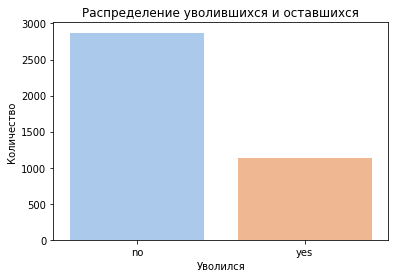

In [29]:
# 3.1. Распределение целевого признака

plt.figure(figsize=(6, 4))
sns.countplot(data=train_quit_df, x="quit", palette="pastel")
plt.title("Распределение уволившихся и оставшихся")
plt.xlabel("Уволился")
plt.ylabel("Количество")
plt.show()

In [30]:
def barplot_percent(col):
    plt.figure(figsize=(7, 4))
    
    # Расчёт доли уволившихся для каждого значения признака
    prop = train_quit_df[train_quit_df['quit'] == 'yes'].groupby(col)['quit'].count() / train_quit_df.groupby(col)['quit'].count()
    prop = prop.fillna(0)  # Заполняем пропущенные значения 0, если для категории нет уволившихся
    
    # Построение графика
    prop.sort_values(ascending=False).plot(kind="bar", color="blue")
    plt.title(f"Доля уволившихся по признаку '{col}'")
    plt.ylabel("Доля уволившихся")
    plt.xlabel(col)
    plt.xticks(rotation=45)
    plt.grid(True, axis='y')
    plt.show()

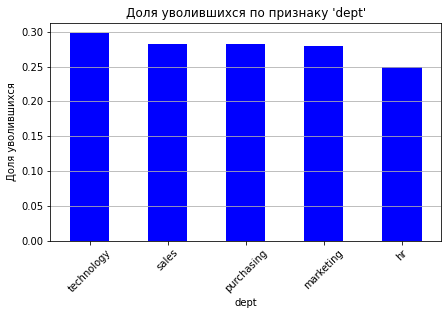

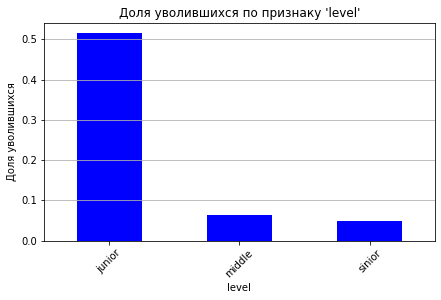

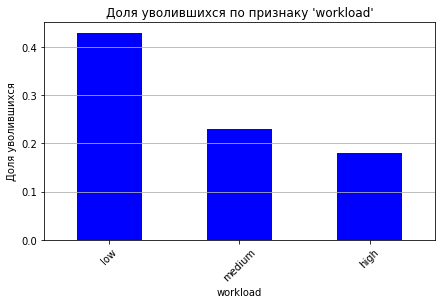

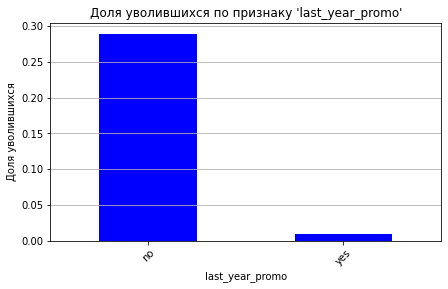

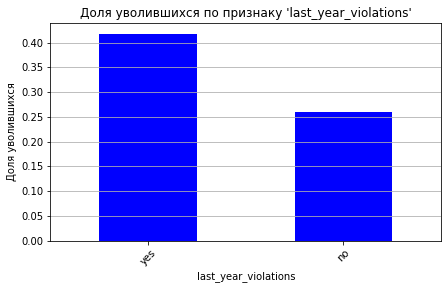

In [31]:
for col in ["dept", "level", "workload", "last_year_promo", "last_year_violations"]:
    barplot_percent(col)

Уволившиеся сотрудники составляют около 25% от общего числа штата.


Чаще всего увольнения происходят в техническом отделе.  доля уволившихся в hr-отделе меньше от стальных и составляет 0.25.

Преимущественно увольняются начинающие специалисты. Это может быть связано с множеством факторов, например, несоответствие условий труда ожиданиям или несовместимость с коллективом. Сеньоры и миддлы увольняются крайне редко.


Сотрудники с низким уровнем загруженности увольняются чаще всего, возможно, из-за недостаточной вовлеченности или недостатка интересных задач. Это может быть связано с тем, что к этой категории относятся в основном начинающие специалисты, о которых было написано ранее. Работники с высокой нагрузкой увольняются реже всего, возможно, это связано с высоким уровнем занимаемой должности и повышенным уровнем ответственности.


Чаще всего увольняются сотрудники не получившие повышения в прошлом году, но данный признак изначально распределен неравномерно и повышение получило малое количество работников.

40% из тех, кто нарушил условия трудового договора попадали под увольнения, следовательно, сотрудники с нарушениями имеют более высокий риск увольнения.

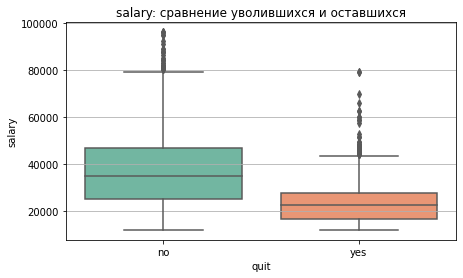

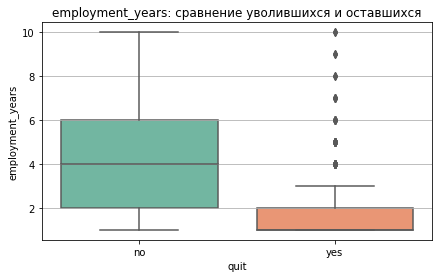

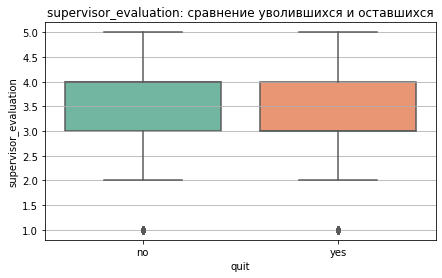

In [32]:
# Числовые признаки — сравнение уволившихся и оставшихся
num_cols = ["salary", "employment_years", "supervisor_evaluation"]

for col in num_cols:
    plt.figure(figsize=(7, 4))
    sns.boxplot(data=train_quit_df, x="quit", y=col, palette="Set2")
    plt.title(f"{col}: сравнение уволившихся и оставшихся")
    plt.grid(True, axis='y')
    plt.show()

Средняя зарплата уволившегося работника составляет 25 тысяч. Наиболее высокая вероятность увольнения приходится на работников, зарабатывающих от 15 до 27 тысяч

Сотрудники с зарплатой более 45 тысяч имеют меньший риск увольнения.  


Годы работы в компании: медиана близка к нулю, следовательно большинство уволившихся сотрудников работало в организации менее года. Это подтверждает установленные ранее выводы о том, что увольнения чаще всего касаются начинающих сотрудников. Присутствуют выбросы, связанные с тем, что увольняются сотрудники  имеющие и более внушающий стаж работы, но редко. Основной разброс находится в диапазоне от 0 до 3 лет. То есть с увеличением стажа в компании риск увольнения снижается. 

Оценка качества работы руководителем не имеет значимого влияния на риск увольнения, так как разброс оценок примерно одинаков в обеих группах.

3.3. Аналитики утверждают, что уровень удовлетворённости сотрудника работой в компании влияет на то, уволится ли сотрудник. Проверим это утверждение: визуализируем и сравним распределения признака job_satisfaction_rate для ушедших и оставшихся сотрудников. 

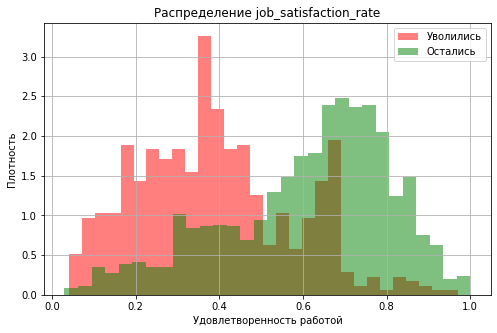

In [33]:
# Объединяем тестовую выборку для анализа 
test_targets = test_target_df.merge(test_target_quit_df, on="id")

# Построение графика распределения
plt.figure(figsize=(8, 5))

# Гистограмма для уволившихся
plt.hist(
    test_targets[test_targets["quit"] == "yes"]["job_satisfaction_rate"],
    bins=30,
    alpha=0.5,
    label="Уволились",
    color="red",
    density=True
)

# Гистограмма для оставшихся
plt.hist(
    test_targets[test_targets["quit"] == "no"]["job_satisfaction_rate"],
    bins=30,
    alpha=0.5,
    label="Остались",
    color="green",
    density=True
)

# Добавление заголовка, меток и легенды
plt.title("Распределение job_satisfaction_rate")
plt.xlabel("Удовлетворенность работой")
plt.ylabel("Плотность")
plt.legend()
plt.grid(True)

plt.show()

Нулевая гипотеза (H0): распределения job_satisfaction_rate у уволившихся и оставшихся одинаковы и уровень удовлетворённости не влияет на факт увольнения.


Альтернативная гипотеза (H1): распределения различаются и уровень удовлетворённости влияет на факт увольнения.

In [34]:
# Выборки
satisfaction_quit_yes = test_targets[test_targets["quit"] == "yes"]["job_satisfaction_rate"]
satisfaction_quit_no = test_targets[test_targets["quit"] == "no"]["job_satisfaction_rate"]

# Проведение t-теста
stat, p_value = ttest_ind(satisfaction_quit_yes, satisfaction_quit_no, equal_var=False)

print(f"t-статистика: {stat:.2f}")
print(f"p-value: {p_value:.5f}")
alpha = 0.05
if p_value < alpha:
    print("Различия статистически значимы — отвергаем H0.")
else:
    print("Различия незначимы — не отвергаем H0.")

t-статистика: -23.80
p-value: 0.00000
Различия статистически значимы — отвергаем H0.



У сотрудников, которые уволились, уровень удовлетворенности работой преимущественно ниже, с пиком около 0.4. Это может говорить о том, что недовольство условиями труда является значимым фактором увольнения.
Сотрудники, которые остались, чаще имеют высокий уровень удовлетворенности с пиком около 0.7, что указывает на связь между позитивной оценкой условий труда и решением остаться в компании. Низкая удовлетворенность работой, особенно на уровне 0.4 и ниже, может являться ключевым предвестником увольнения сотрудников.


Гистограмма сотрудников, которые остались, демонстрирует более широкий диапазон значений, но с явным скоплением в более высоких уровнях удовлетворенности. Уволившиеся сотрудники распределены более узко в сторону низких значений удовлетворенности.


Анализ данных показал, что уволившиеся сотрудники составляют около 25% штата. Наибольшая доля увольнений наблюдается среди начинающих специалистов (`junior`) в техническом отделе, особенно с низкой загруженностью и зарплатой в диапазоне 15–27 тысяч. Стаж менее года также увеличивает риск увольнения. Нарушение трудового договора сильно связано с уходом — 40% сотрудников с нарушениями покидают компанию.

Уровень удовлетворённости оказался ключевым фактором: уволившиеся имеют низкую удовлетворённость с пиком около 0.4, тогда как оставшиеся чаще демонстрируют высокий уровень с пиком около 0.7. Эти факты подтверждают связь между удовлетворённостью и увольнениями и формируют профиль сотрудников с высоким риском. Использование этих признаков для предсказания может помочь компании снизить текучесть кадров.

### Этап 4:  Добавление нового входного признака


Добавим job_satisfaction_rate, предсказанный лучшей моделью первой задачи, к входным признакам второй задачи.

In [35]:
# Сравнение id и предсказанных значений
train_quit_df['job_satisfaction_rate'] = best_model.predict(train_quit_df.drop(['id', 'quit'], axis=1))
test_features_df['job_satisfaction_rate'] = best_model.predict(test_features_df.drop('id', axis=1))

# Проверяем соответствие id и новых предсказаний
display(train_quit_df.head())
display(test_features_df.head())

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit,job_satisfaction_rate
0,723290,sales,middle,high,2,no,no,4,54000,no,0.614440
1,814010,sales,junior,medium,2,no,no,4,27600,no,0.819104
2,155091,purchasing,middle,medium,5,no,no,1,37200,no,0.443589
3,257132,sales,junior,medium,2,no,yes,3,24000,yes,0.299994
4,910140,marketing,junior,medium,2,no,no,5,25200,no,0.800318


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,100298,hr,junior,low,2,no,no,4,19200,0.816936
1,100480,marketing,junior,low,4,no,no,4,16800,0.818087
2,100503,purchasing,middle,high,5,no,no,4,55200,0.775385
3,100610,sales,middle,medium,5,no,no,4,43200,0.778473
4,100692,sales,middle,high,6,no,no,4,48000,0.775102


### Этап 5: Подготовка данных

Подготовим признаки так же, как и в первой задаче: выполним подготовку в пайплайне, дополнив пайплайн предобработки. При кодировании учтем особенности признаков и моделей и используем как минимум два кодировщика.

In [36]:
# Сортировка и сброс индекса для каждой таблицы
train_quit_df = train_quit_df.sort_values(by='id').reset_index(drop=True)
test_features_df = test_features_df.sort_values(by='id').reset_index(drop=True)
test_target_quit_df = test_target_quit_df.sort_values(by='id').reset_index(drop=True)

# Загрузка данных
X_train = train_quit_df.drop(['id', 'quit'], axis=1)
y_train = train_quit_df['quit']

X_test = test_features_df.drop(['id'], axis=1)
y_test = test_target_quit_df['quit']

print(X_train.shape, X_test.shape)

from sklearn.preprocessing import LabelEncoder

# Кодирование целевого признака 
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train) 
y_test = label_encoder.transform(y_test)      



# Списки признаков
ohe_columns = ['dept', 'last_year_promo', 'last_year_violations']
ord_columns = ['level', 'workload']
num_columns = ['employment_years', 
               'supervisor_evaluation',
               'salary', 'job_satisfaction_rate'
               ]

# Пайплайн для OHE-кодирования
ohe_pipe = Pipeline([
    ('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
    ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False))
])

# Пайплайн для Ordinal-кодирования
ord_pipe = Pipeline([
    ('simpleImputer_before_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
    ('ord', OrdinalEncoder(
        categories=[
            ['junior', 'middle', 'sinior'], 
            ['low', 'medium', 'high']
        ], 
        handle_unknown='use_encoded_value', unknown_value=np.nan
    )),
    ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
])

# Пайплайн для числовых данных с добавлением полиномиальных признаков
num_pipe = Pipeline([
    ('imputer', SimpleImputer(missing_values=np.nan, strategy='mean')),
    ('scaler', StandardScaler()),
    ('poly', PolynomialFeatures(degree=2, include_bias=False)), 
    ('select', SelectKBest(score_func=f_classif, k='all'))   
])

# Общий ColumnTransformer для подготовки данных
data_preprocessor = ColumnTransformer([
    ('ohe', ohe_pipe, ohe_columns),
    ('ord', ord_pipe, ord_columns),
    ('num', num_pipe, num_columns)
], remainder='passthrough')

data_preprocessor

(4000, 9) (2000, 9)


ColumnTransformer(remainder='passthrough',
                  transformers=[('ohe',
                                 Pipeline(steps=[('simpleImputer_ohe',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('ohe',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 ['dept', 'last_year_promo',
                                  'last_year_violations']),
                                ('ord',
                                 Pipeline(steps=[('simpleImputer_before_ord',
                                                  SimpleImputer(strategy='m...
                                                                 unknown_value=nan)),
                                                 ('simpleImputer_after_ord',
                                                  SimpleImputer(strategy='most_frequent'))]),
                                 ['level', 'workload']),
                                ('num',
                                 Pipeline(steps=[('imputer', SimpleImputer()),
                                                 ('scaler', StandardScaler()),
                                                 ('poly',
                                                  PolynomialFeatures(include_bias=False)),
                                                 ('select',
                                                  SelectKBest(k='all'))]),
                                 ['employment_years', 'supervisor_evaluation',
                                  'salary', 'job_satisfaction_rate'])])

### Этап 6: Обучение модели

Обучим как минимум три модели. Как минимум для двух из них подберем гиперпараметры. Проверим качество лучшей модели.

Метрика оценки качества в этой задаче — ROC-AUC. Критерий успеха: ROC-AUC ≥ 0.91 на тестовой выборке. 

In [37]:
# Финальный пайплайн
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
])

# Словари параметров
param_grid = [
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 5),
        'models__max_features': range(2, 5),
        'preprocessor__num__poly__degree': [1, 2, 3]
    },
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(2, 5),
        'preprocessor__num__poly__degree': [1, 2]
    },
    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE, 
            solver='liblinear', 
            penalty='l1'
        )],
        'models__C': range(1, 10),
        'preprocessor__num__poly__degree': [1, 2]
    },
    {
        'models': [SVC(probability=True)],
        'models__kernel': ['linear', 'rbf', 'sigmoid', 'poly'],
        'preprocessor__num__poly__degree': [1, 2]
    }
]

# Поиск с кросс-валидацией
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
search = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    cv=cv, 
    scoring='roc_auc', 
    random_state=RANDOM_STATE, 
    n_jobs=-1,
    verbose=1
)

# Обучение на тренировочной выборке 
search.fit(X_train, y_train)

# Выводим лучшую модель
print("\nЛучшая модель по результатам кросс-валидации:")
print(search.best_estimator_)
print("ROC-AUC (кросс-валидация):", search.best_score_)

# тестирование на тестовой выборке
best_model = search.best_estimator_
y_test_proba = best_model.predict_proba(X_test)[:, 1]
roc_auc_test = roc_auc_score(y_test, y_test_proba)
print(f"ROC-AUC на тестовой выборке: {roc_auc_test:.4f}")

Fitting 5 folds for each of 10 candidates, totalling 50 fits

Лучшая модель по результатам кросс-валидации:
Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['dept', 'last_year_promo',
                                                   'last_year_violations']),
         

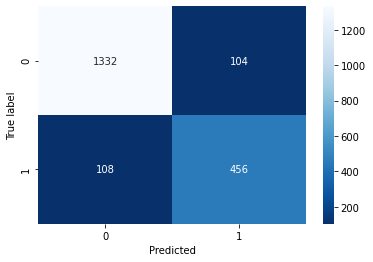

In [38]:
# построим матрицу ошибок
y_pred = best_model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues_r')
plt.ylabel('True label')
plt.xlabel('Predicted'); 

456 значений TP и 1332 TN, это означает, что большинство данных модель классифицирует верно и следовательно, с помощью нее компания сможет заранее предупреждать увольнение сотрудника.

104 ошибки первого рода, этих сотрудников модель определила как уволившихся, хотя на самом деле они остались в компании.  

108 ошибок второго рода, означающих, что этих сотрудников модель отнесла к классу 0, но на самом деле они уволились. эти ошибки (FN) наиболее критичны для компании, так как они не смогли предупредить увольнение 108 человек, а это могли быть очень ценные сотрудники, вносящие большой вклад в успешное функционирование организации. в будущем стоит работать над тем, чтобы модель совершала как можно меньше подобных ошибок и верно классифицировала увольнение работников.

### Этап 7:  Выводы


Лучшая модель использует SVC (метод опорных векторов) с ядром poly (полиномиальное ядро).
Такая модель хорошо подходит для данной задачи, так как признаки имеют сложные нелинейные зависимости, что подтверждается высокой точностью метрик


Метрика ROC-AUC на тренировочной выборке составила 0.928, что свидетельствует о том, что модель хорошо различает классы "уволился" и "остался" на обучающих данных.
высокое ROC-AUC указывает на способность модели корректно классифицировать, избегая перекоса в сторону какого-либо класса.

ROC-AUC на тестовой выборке: 0.924, что говорит о хорошей обобщающей способности модели. Разница между тренировочной и тестовой метрикой небольшая, следовательно значительного переобучения удалось миновать.


SVC с полиномиальным ядром оказался наиболее эффективной моделью для задачи. Высокое значение ROC-AUC на тестовых данных подтверждает, что модель способна с высокой точностью предсказывать вероятность увольнения сотрудника.


## Общий вывод

**Проект состоял из двух задач:**
    
1. Предсказание уровня удовлетворённости сотрудника работой — построение модели для оценки показателя job_satisfaction_rate.
2. Прогноз увольнения сотрудника из компании — построение модели для классификации риска увольнения на основе различных признаков, включая предсказанный уровень удовлетворённости.

**Этапы работы**

1. Загрузка данных: Исходные данные из трех таблиц для первой задачи и двух таблиц для второй были изучены, объединены и обработаны.
2. Предобработка данных: Проведена очистка данных, включающая обработку пропусков, проверку дублированных строк и приведение структуры данных к единому виду. Пропуски заполнялись наиболее частыми значениями или средними для числовых признаков. Аномалий и выбросов не выявлено.
3. Исследовательский анализ данных: Построены графики распределения признаков, выявлены взаимосвязи. Основные факторы, влияющие на удовлетворённость и увольнение, были идентифицированы, включая уровень загруженности, отдел, стаж работы и уровень зарплаты.
4. Подготовка данных: Созданы единые пайплайны обработки данных с использованием кодирования категориальных признаков (One-Hot Encoding и Ordinal Encoding), нормализации числовых данных (StandardScaler) и создания полиномиальных признаков (PolynomialFeatures). Для отбора значимых признаков применялся SelectKBest.
5. Обучение моделей:
    - Первая задача: Обучены линейная регрессия и случайный лес с подбором гиперпараметров через RandomizedSearchCV. Лучшая модель — случайный лес.
    - Вторая задача: Обучены три классификационные модели, включая SVC, дерево решений и логистическую регрессию. Лучшая модель — SVC с полиномиальным ядром, которая достигла метрики ROC-AUC = 0.924.
6. Анализ результатов: Проведен анализ коэффициентов линейной регрессии и значимости признаков дерева решений. Наиболее важные признаки включали зарплату, стаж работы, уровень удовлетворённости и оценку руководителя.


**Предсказание уровня удовлетворённости:**

    Дерево решений показало наилучшие результаты с метрикой SMAPE = 14.95 на тестовой выборке.
Уровень зарплаты, стаж работы и оценка руководителя оказались ключевыми факторами, влияющими на удовлетворённость. Сотрудники с высокой зарплатой, большим стажем работы и положительной оценкой руководителя чаще довольны работой.


**Прогноз увольнения:**
    
Наилучшая модель SVC достигла ROC-AUC = 0.924, подтвердив свою способность предсказывать вероятность увольнения с высокой точностью.
Уволившиеся сотрудники чаще всего характеризуются низкой загруженностью, минимальным стажем, зарплатой ниже 27 тысяч и неудовлетворённостью работой.


**Рекомендации для бизнеса**


 Удержание сотрудников:
1. Ввести регулярный мониторинг уровня удовлетворённости сотрудников, используя результаты модели предсказания job_satisfaction_rate.
2. Уделить внимание группе с высоким риском увольнения: начинающим специалистам с низкой загруженностью и неудовлетворённостью работой.


Улучшение условий труда:
1. Предлагать повышение карьерные перспективы сотрудникам с минимальным стажем и низкой удовлетворённостью.
2. Организовать программы повышения мотивации для сотрудников с низкой загруженностью.


Прогнозирование риска увольнения:
1. Интегрировать модель в HR-систему для анализа данных в реальном времени и быстрого выявления сотрудников с высоким риском ухода.

